In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize
## bigantscan_CF_13strap_2passive_

In [2]:
# this notebook is to test that everything in center fed mode works as expected
num_straps = 11
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(81,112, 1)
capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'
antfile = 'circ_model/fixed_bigscan_full_CF_11strap.csv' 
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile, center_fed_mode=True)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
num_straps:     11
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


In [6]:
# Testing out the differential evolution optimization method 
# confirm class version works 
# bigantscan_CF_13strap_2passive_
bounds = [(0.05, 0.154)]*6#[(0.02, 0.095)]*5
freq_bounds = (94, 98)  # (90, 102) got ok behavior
s11cutoff = -45

res = myrfTWA.run_differential_evolution_global_op(bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq_bounds=freq_bounds,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.09712167 0.07764726 0.06646162 0.14826554 0.10311451 0.0540653 ]
Average absolute error is : 7.05e+03
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.11543825 0.10881864 0.11143169 0.05594835 0.12657194 0.13295747]
Average absolute error is : 9.50e+03
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.06520659 0.12928759 0.10945692 0.05574546 0.09079414 0.05095886]
Average absolute error is : 8.90e+03
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.08260228 0.08366295 0.08318271 0.11992152 0.07629701 0.11713383]
Average absolute error is : 6.95e+03
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.11658118 0.13820714 0.08479461 0.06699748 0.14644113 0.11823396]
Average absolute error is : 9.97e+03
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.0932

KeyboardInterrupt: 

In [7]:
lengths_found = res.x.tolist()
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

NameError: name 'res' is not defined

In [ ]:
#lengths = [0.1311778221225474, 0.11519046885602385, 0.14010718256369714, 0.12735421956841164, 0.1431832918398686] # these are for the < -45 dB, beta = 100, f = 92 to 100
#lengths = [0.12810392247316846, 0.11046490960219796, 0.13937978734857429, 0.10464024587092911, 0.05006480615180657]
#lengths = [0.12911761266805222, 0.11244327657923738, 0.12655033132747448, 0.0899094492869507, 0.10329754709139226]
lengths = lengths_found.copy()
print(lengths)
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths, symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0, 0] # power excitation at the three ports 
phase = [0, 0, 0] # radians 
print('port indicies', full_circ.port_indexes)
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
# print(full_circ.currents(power,phase).shape)
print(full_circ.frequency.f_scaled)
print(full_circ.currents(power,phase)[2,:])
print('--')
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

[0.12730705525034275, 0.09088673513895376, 0.06853073829013923, 0.08280134776154466, 0.07127996092272645, 0.11884455385772133]
port indicies [1, 3, 5]
[ 81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111.]
[ 0.23714212-0.04477177j -0.23714212+0.04477177j  0.0007034 -0.18288773j
 -0.0007034 +0.18288773j  0.01301603-0.18152153j -0.01301603+0.18152153j
  0.15716712+0.16311351j -0.15716712-0.16311351j -0.03354163+0.2638423j
  0.03354163-0.2638423j  -0.10374606+0.1672137j   0.10374606-0.1672137j
 -0.20372071+0.15422443j  0.20372071-0.15422443j -0.15317365+0.02130402j
  0.15317365-0.02130402j -0.15981288-0.18690113j  0.15981288+0.18690113j
 -0.15791729+0.01685725j  0.15791729-0.01685725j -0.21534229+0.14364978j
  0.21534229-0.14364978j -0.11333017+0.16127887j  0.11333017-0.16127887j
 -0.05238713+0.25957582j  0.05238713-0.25957582j  0.14505211+0.1725187j
 -0.14505211-0.1725187j ]
--
[ 0.141

[ 0.33043523  0.82014283 -0.85608263 -0.51099016 -0.16007882  0.21259566
 -0.16333781 -0.50256945 -0.85714306  0.82465847  0.33465329]


Text(0, 0.5, 'P(n||) [arb]')

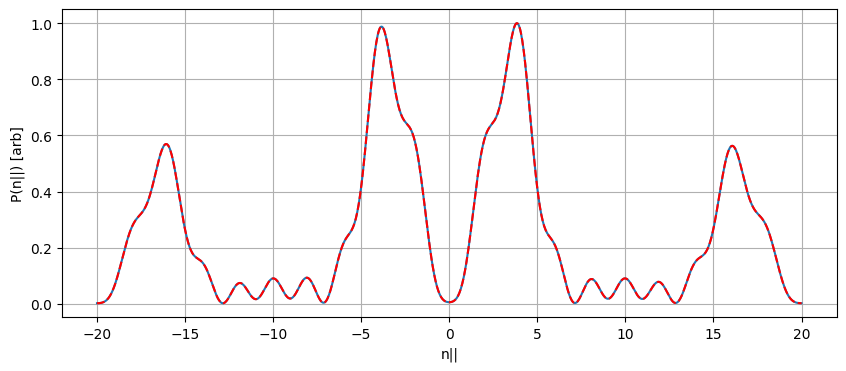

In [ ]:
npar_array = np.linspace(-20, 20, 1000)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)))


# try adjusting phases by a constant 

strap_phases2 = strap_phases #+ np.array([40, 60, 20, 25, 3, 45, 180, 8, 12]) * (np.pi/180)
result2 = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases2)
    result2 = np.append(result2, power)

plt.plot(npar_array, np.real(result2)/np.max(np.real(result2)), color='red', linestyle='--')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

[  38.76533735  -57.52564163 -179.03263026   54.55775664  -74.88705166
  156.8699224    31.06947552  -92.07114936  173.17510261]
d:  0.15625
wstrap:  0.08


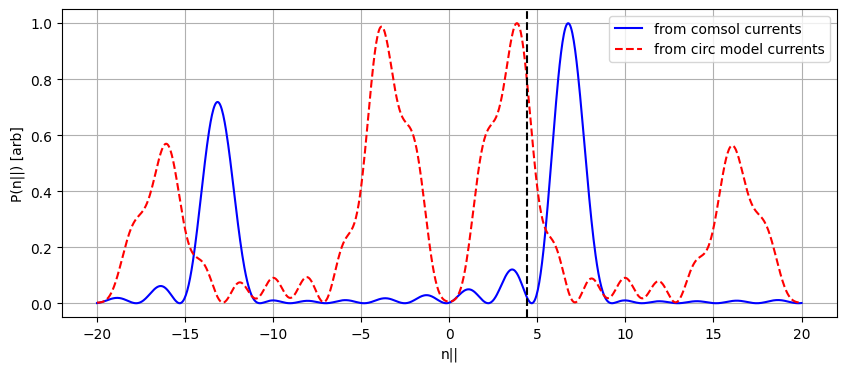

In [ ]:
cap_currents = np.array([0.0031801+0.0025537*1j, 0.0029809-0.0046837*1j, -0.0056296-9.5058E-5*1j, 0.0038771+0.0054471*1j, 0.0015648-0.0057942*1j, -0.0060589+0.0025881*1j, 0.0048643+0.0029308*1j, -2.0236E-4-0.0055956*1j, -0.0040003+4.7877E-4*1j])
cap_phases = get_phase(cap_currents)
print(cap_phases*180/np.pi)
print('d: ', myrfTWA.geometry_dict['d'])
print('wstrap: ', myrfTWA.geometry_dict['wstrap'])
npar_array = np.linspace(-20, 20, 1000)

result = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=0.085,
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=cap_phases)
    result = np.append(result, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='blue', label='from comsol currents')
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='from circ model currents')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=4.384384384384383, ymin=0, ymax=1, color='k', linestyle='--')

In [8]:
# Now, test out the new optimizer 
bounds = [(0.05, 0.154)]*6#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
alpha = 1000 # 10,000 worked well 
target_npar = 5
npar_bounds = [0, 10]
num_npars = 100


res = myrfTWA.run_differential_evolution_global_op_npar_match( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            target_npar=5,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.07075397 0.09680281 0.12603754 0.094482   0.07961692 0.09256841]
Average absolute error is : 1.49e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.10668066 0.15116103 0.1099758  0.11990542 0.14409664 0.05859608]
Average absolute error is : 2.00e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.05572015 0.11699631 0.07351844 0.11183516 0.09906863 0.14123862]
Average absolute error is : 1.82e+04
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.05721211 0.06649564 0.10303371 0.10820215 0.12576826 0.14420034]
Average absolute error is : 2.03e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.09287178 0.05278478 0.10691476 0.13164837 0.08006245 0.11804458]
Average absolute error is : 1.50e+04
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.1393

KeyboardInterrupt: 

final lengths: [0.12897436571450147, 0.11099561171550754, 0.13090879427973587, 0.09875142541814487, 0.06286721167805734, 0.11188090619104307]


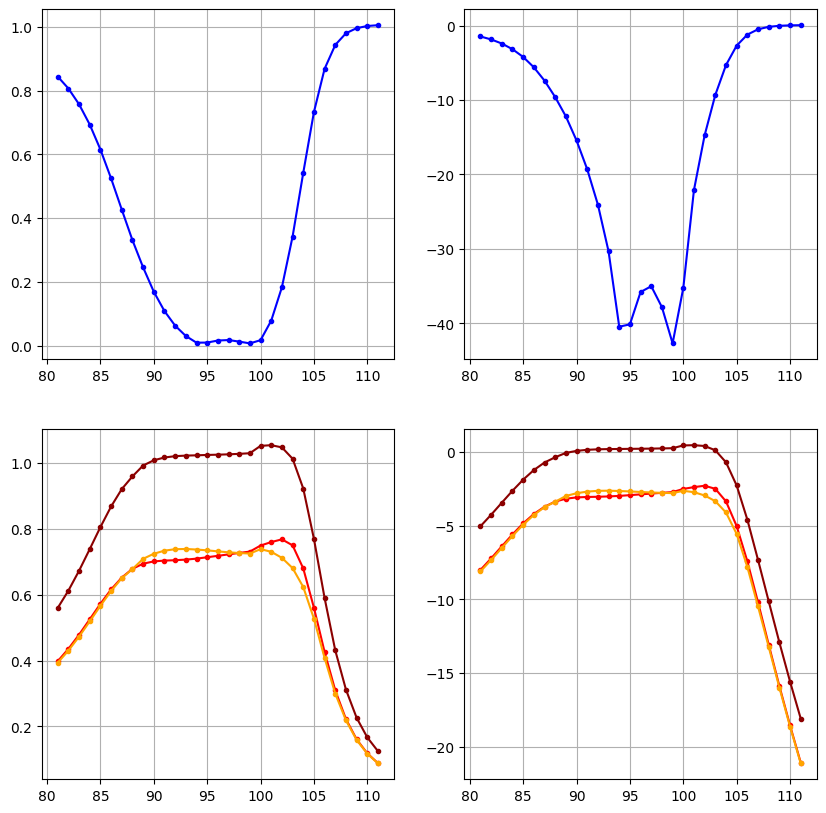

In [ ]:

lengths_found = res.x.tolist()
#lengths_found = [0.1289090871537399, 0.1120736062752666, 0.125719368082663, 0.08986244957445322, 0.10298948480135928]
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

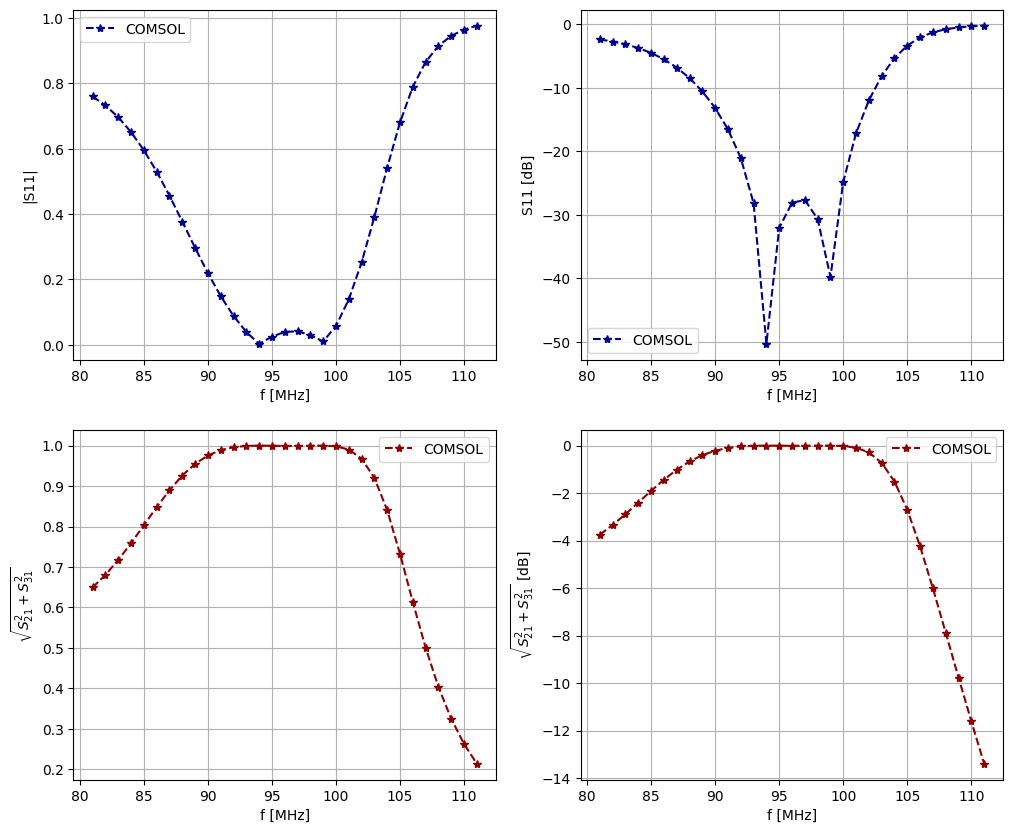

In [ ]:
# compare reflections to result 
filename = 'circ_model/fscan_CF.csv'
dataset, headers = myrfTWA.get_comsol_datatable(filename)
fd = dataset[:, 0]
S11d = dataset[:,1]
S21d = dataset[:,2]
S31d = dataset[:,3]

S11d_mag = np.abs(S11d)
S21d_mag = np.abs(S21d)
S31d_mag = np.abs(S31d)

S_transd_mag = np.sqrt(S21d_mag**2 + S31d_mag**2) 

S11d_db = 20*np.log10(S11d_mag)
S_transd_db = 20*np.log10(S_transd_mag)



fig, ax = plt.subplots(2,2,figsize=(12,10))

# # plot optimization circuit
# ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue', label='circuit model')
# ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue', label='circuit model')
# ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='red', label='circuit model')
# ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='red', label='circuit model')

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

# plot data

ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S_transd_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S_transd_db, marker='*', color='darkred', label='COMSOL',linestyle='--')


ax[0,0].set_xlabel('f [MHz]')
ax[0,1].set_xlabel('f [MHz]')
ax[1,0].set_xlabel('f [MHz]')
ax[1,1].set_xlabel('f [MHz]')

ax[0,0].set_ylabel('|S11|')
ax[0,1].set_ylabel('S11 [dB]')
ax[1,0].set_ylabel(r'$\sqrt{S_{21}^2 + S_{31}^2}$')
ax[1,1].set_ylabel(r'$\sqrt{S_{21}^2 + S_{31}^2}$ [dB]')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [ ]:
#lengths_found = [0.1289090871537399, 0.1120736062752666, 0.125719368082663, 0.08986244957445322, 0.10298948480135928]
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

port indicies [1, 3, 5]
[ 0.12131521+0.15694214j -0.12131521-0.15694214j -0.08412433-0.07508723j
  0.08412433+0.07508723j -0.08073101-0.07575682j  0.08073101+0.07575682j
  0.13921757-0.00699947j -0.13921757+0.00699947j  0.14146289+0.15611983j
 -0.14146289-0.15611983j  0.0165696 +0.18287326j -0.0165696 -0.18287326j
 -0.11036935-0.07157725j  0.11036935+0.07157725j -0.0867577 -0.12589457j
  0.0867577 +0.12589457j -0.20861655-0.41317172j  0.20861655+0.41317172j
 -0.08550103-0.12556024j  0.08550103+0.12556024j -0.10863732-0.07314962j
  0.10863732+0.07314962j  0.0151838 +0.18103726j -0.0151838 -0.18103726j
  0.13439927+0.15752361j -0.13439927-0.15752361j  0.13681358-0.00346735j
 -0.13681358+0.00346735j]
--
[ 0.24434802-0.15058153j  0.19323223+0.33003064j -0.34809253+0.04141709j
  0.0806722 -0.30186748j  0.14275818-0.05206858j  0.26781465+0.21459959j
  0.13679542-0.05655222j  0.06973662-0.31408251j -0.34296682+0.04804353j
  0.20113387+0.32813j     0.24122303-0.15567847j]
[-31.64380287  59.651

[-0.1757989   0.3313951   0.96230376 -0.41687621 -0.11132538  0.21502866
 -0.12478086 -0.43045297  0.95569874  0.32496083 -0.18242803]


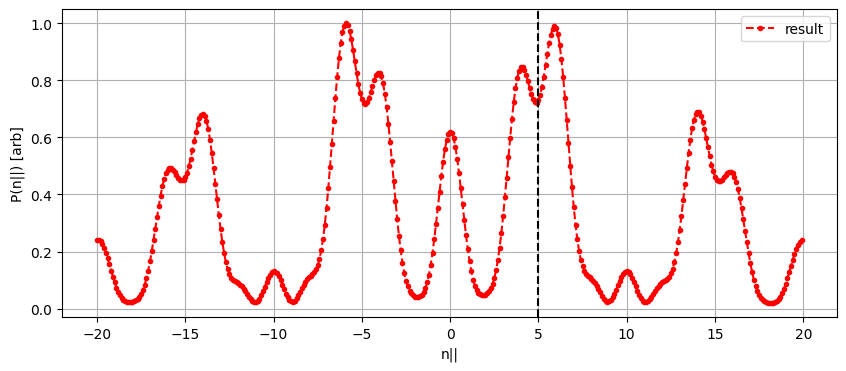

In [ ]:
npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=5, ymin=0, ymax=1, color='k', linestyle='--')

[  36.79528046  127.78288966 -116.82108314  -16.10654897   38.73879892
  -16.13581359 -116.87639976  127.70291119   36.66689648]
d:  0.15625
wstrap:  0.08


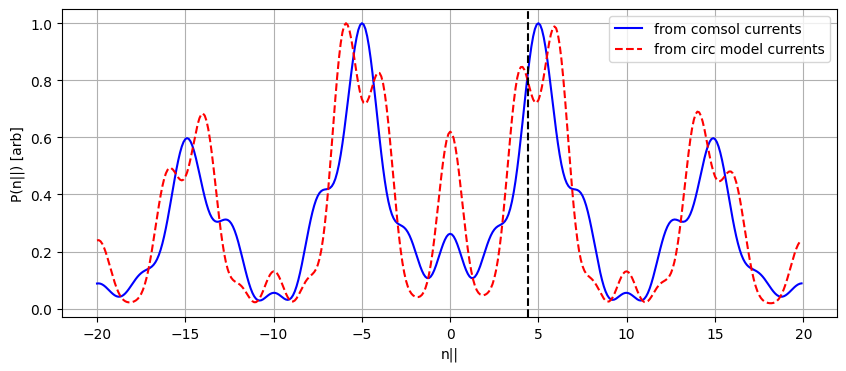

In [ ]:
# compare current fourier transform 

cap_currents=[0.0022382+0.0016741*1j, -0.0023201+0.0029929*1j, -0.0014721-0.0029116*1j, 0.0025149-7.2620E-4*1j, 0.0023592+0.0018927*1j, 0.0025132-7.2710E-4*1j, -0.0014733-0.0029070*1j, -0.0023111+0.0029899*1j, 0.0022413+0.0016686*1j] 
cap_phases = get_phase(cap_currents)
print(cap_phases*180/np.pi)
print('d: ', myrfTWA.geometry_dict['d'])
print('wstrap: ', myrfTWA.geometry_dict['wstrap'])

result = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=0.085,
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=cap_phases)
    result = np.append(result, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='blue', label='from comsol currents')
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='from circ model currents')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=4.384384384384383, ymin=0, ymax=1, color='k', linestyle='--')

In [9]:
# Now, test out the new optimizerthat has n|| = 0 weighting. 
bounds = [(0.05, 0.154)]*6#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
alpha = 2000 # 10,000 worked well 
gamma = 1500
target_npar = 5 # TODO: change back to 5
npar_bounds = [0, 10]
num_npars = 100


res = myrfTWA.run_differential_evolution_global_op_npar_match_low_npar_zero( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            gamma_npar_op=gamma,
                                            target_npar=5,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.06913654 0.07692591 0.14073378 0.09778204 0.13744793 0.11084006]
Average absolute error is : 2.76e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.10903509 0.05521463 0.12837723 0.06534238 0.10466472 0.08960489]
Average absolute error is : 2.15e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.08441499 0.13491704 0.06943325 0.10340938 0.09404477 0.05885675]
Average absolute error is : 2.06e+04
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.05353697 0.14240794 0.05135202 0.05815478 0.11184837 0.13545301]
Average absolute error is : 1.93e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.08863778 0.13047374 0.10371007 0.07054823 0.05526766 0.09058172]
Average absolute error is : 1.97e+04
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.1280

KeyboardInterrupt: 

final lengths: [0.12673814414349627, 0.09010787047944502, 0.06626349841982251, 0.08112687910524499, 0.07001781132844762, 0.11926309298469763]


C:\Users\jacob\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


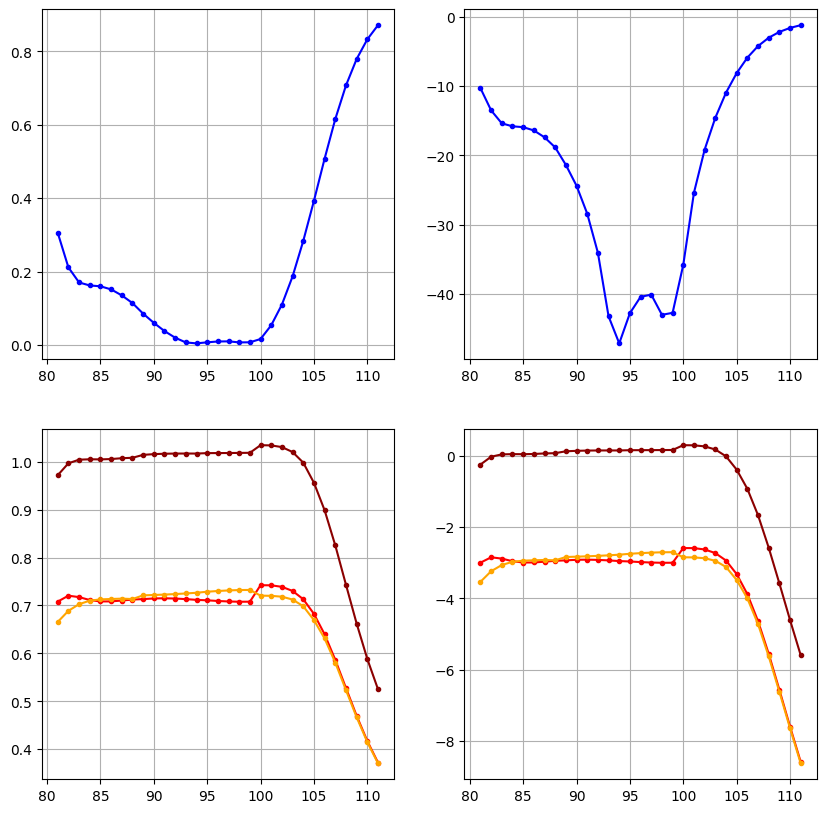

In [10]:
#lengths_found = res.x.tolist()
#lengths_found = [0.1289090871537399, 0.1120736062752666, 0.125719368082663, 0.08986244957445322, 0.10298948480135928]
# low zero, terrible reflections [0.12876049654923688, 0.09515033826794814, 0.08941864328597232, 0.08651663399900549, 0.10821744956900059]
#lengths_found = [0.12878498970230015, 0.08931114684940449, 0.08346384970617532, 0.11280919187444016, 0.15391258736764307]
lengths_found = [0.12673814414349627, 0.09010787047944502, 0.06626349841982251, 0.08112687910524499, 0.07001781132844762, 0.11926309298469763]
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

In [11]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

port indicies [1, 3, 5]
[ 0.30260965-0.03167584j -0.30260965+0.03167584j  0.07771129-0.16830179j
 -0.07771129+0.16830179j  0.08554641-0.15578856j -0.08554641+0.15578856j
  0.07634554+0.21156012j -0.07634554-0.21156012j -0.13021533+0.23464332j
  0.13021533-0.23464332j -0.15686524+0.12708422j  0.15686524-0.12708422j
 -0.2651735 +0.10995826j  0.2651735 -0.10995826j -0.19352877+0.01255572j
  0.19352877-0.01255572j -0.21945249-0.14509967j  0.21945249+0.14509967j
 -0.19308312+0.00422697j  0.19308312-0.00422697j -0.26571133+0.09090208j
  0.26571133-0.09090208j -0.15857494+0.1133259j   0.15857494-0.1133259j
 -0.14129608+0.21508858j  0.14129608-0.21508858j  0.05892022+0.20743171j
 -0.05892022-0.20743171j]
--
[ 0.11377148+0.25252062j -0.25524784+0.12953179j -0.13329468-0.0777887j
 -0.00199142-0.23786809j  0.14102565-0.07918699j  0.28356753+0.22127166j
  0.1442568 -0.08196081j  0.00481887-0.2426298j  -0.13480224-0.07855222j
 -0.26334101+0.1280425j   0.11159687+0.25868506j]
[  65.74637179  153.093

[ 0.36525762  0.85051869 -0.83184905 -0.50266481 -0.16285859  0.21091894
 -0.1644637  -0.49367887 -0.83205393  0.85594392  0.37035893]


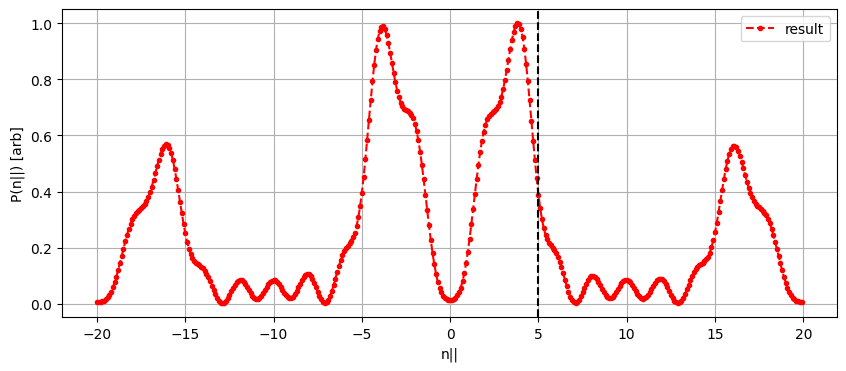

In [12]:
npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=5, ymin=0, ymax=1, color='k', linestyle='--')

In [13]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.12673814414349627, 0.09010787047944502, 0.06626349841982251, 0.08112687910524499, 0.07001781132844762, 0.11926309298469763]
The phase difference is 87.34699310564652 deg
The power ratio I_2^2 / I_1^2 = 1.068039167016664


In [14]:
phase1 = -43
phase2 = 90 + 41
phasediff = (phase2%360) - (phase1%360)
print(phasediff)
print(phasediff%360)

-186
174


In [14]:
# try out the knew optimization function. Start with very low alpha and beta, and lamda largeish. 
bounds = [(0.05, 0.154)]*6#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
alpha = 0 # 10,000 worked well 
gamma = 0
lam1 = 10000 # phase op
lam2 = 10000 # power ratio op 
target_npar = 5 # TODO: change back to 5
target_PR = 2 # TODO: I do not know what the desired power ratio is. 
npar_bounds = [0, 10]
num_npars = 100


res = myrfTWA.run_differential_evolution_global_op_npar_match_low_npar_zero_cancel_image_currents( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            gamma_npar_op=gamma,
                                            target_npar=5,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            lam1_image_current_phase_op=lam1,
                                            lam2_image_current_mag_op=lam2,
                                            target_power_ratio_image_current_op=target_PR,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False,
                                            workers=1)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.12430049 0.0670162  0.14422572 0.12414671 0.13322754 0.09729096]
Average absolute error is : 8.95e+04
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.15264051 0.12321923 0.12551836 0.11460866 0.14988882 0.08725436]
Average absolute error is : 2.78e+04
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.15313891 0.14888367 0.0969948  0.06575461 0.10569915 0.090694  ]
Average absolute error is : 1.13e+05
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.1442394  0.06954905 0.08974975 0.13608135 0.06174365 0.08017566]
Average absolute error is : 8.06e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.07129624 0.12094364 0.08644306 0.08361564 0.08230734 0.12074534]
Average absolute error is : 1.02e+07
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.0905

In [15]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
lengths_found = res.x.tolist()
#lengths_found = [0.13254054, 0.09346692, 0.0602741, 0.07834545, 0.06088853, 0.11657295]
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.15336775198577418, 0.1199581684765616, 0.15045655858278786, 0.10352694025812333, 0.05, 0.11926397111787722]
The phase difference is 123.19441407883733 deg
The power ratio I_2^2 / I_1^2 = 2.0731969627556026


final lengths: [0.15336777965063536, 0.11995811519757942, 0.15045653008997711, 0.10352683812666483, 0.05, 0.11926363358664618]


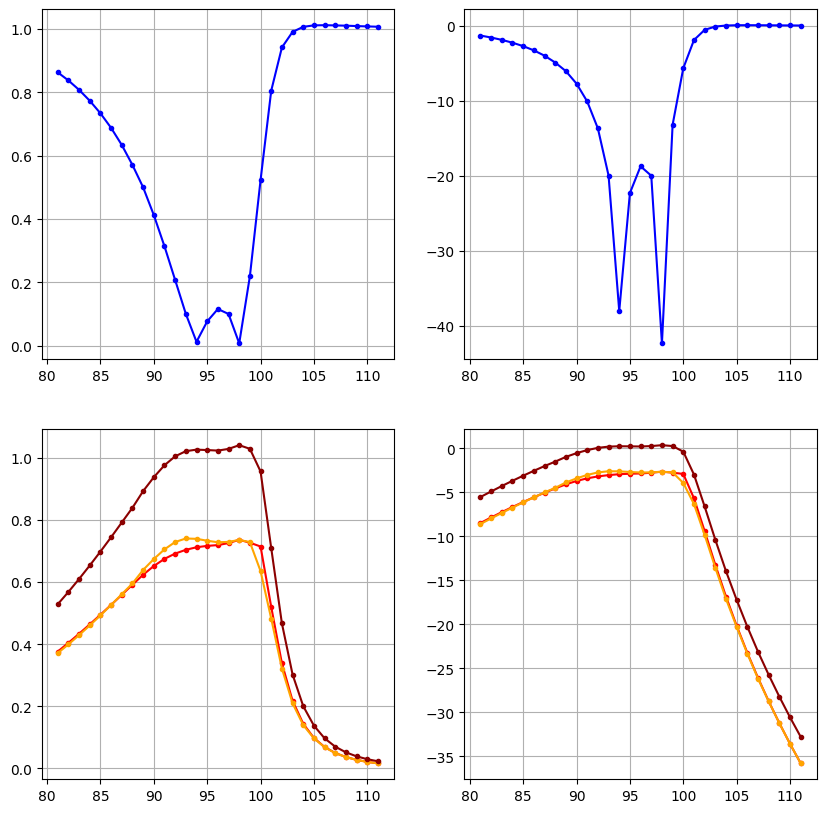

In [12]:
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

port indicies [1, 3, 5]
[ 0.12616888+0.17128282j -0.12616888-0.17128282j -0.10450782-0.00927777j
  0.10450782+0.00927777j -0.10204395-0.0122633j   0.10204395+0.0122633j
  0.12146712-0.10033375j -0.12146712+0.10033375j  0.1508023 +0.09338772j
 -0.1508023 -0.09338772j  0.01809481+0.18977595j -0.01809481-0.18977595j
 -0.11911735-0.08131923j  0.11911735+0.08131923j -0.06131133-0.08706972j
  0.06131133+0.08706972j -0.23879844-0.45022216j  0.23879844+0.45022216j
 -0.06050847-0.08711459j  0.06050847+0.08711459j -0.11789304-0.08435154j
  0.11789304+0.08435154j  0.01543444+0.18640156j -0.01543444-0.18640156j
  0.1447096 +0.09688571j -0.1447096 -0.09688571j  0.12198159-0.09454594j
 -0.12198159+0.09454594j]
--
[-0.00958828-0.35110748j  0.43060758+0.26522423j -0.38604686+0.15046122j
  0.09496617-0.38022708j  0.09268117-0.04119588j  0.31896834+0.24908348j
  0.08805928-0.04180403j  0.0794898 -0.38382548j -0.3766543 +0.15112576j
  0.43207443+0.25729306j -0.01429318-0.34764303j]
[-91.56428344  31.6301

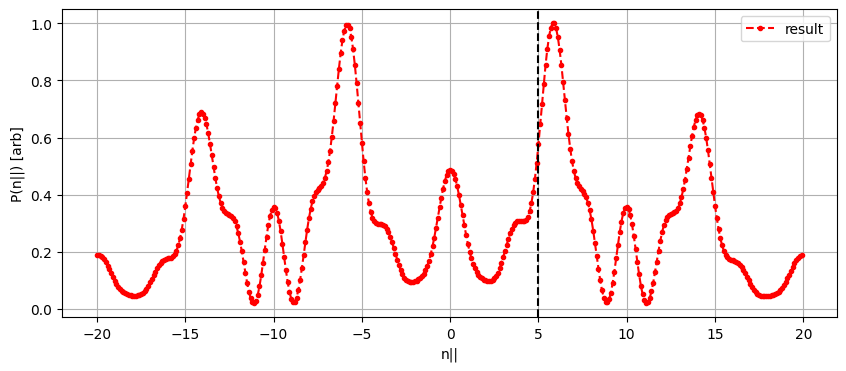

In [13]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=5, ymin=0, ymax=1, color='k', linestyle='--')